In [1]:
import pandas as pd
df = pd.read_csv('train.tsv', sep='\t')
df.head()


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [2]:
#df = df.drop_duplicates(subset=['SentenceId'], keep='first')
#df.head()
#df.shape
!pip install matplotlib

<AxesSubplot:>

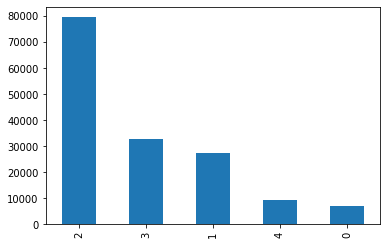

In [3]:
df['Sentiment'].value_counts().plot(kind='bar')

In [4]:
seq_len = 512
num_samples = len(df)
num_samples, seq_len

(156060, 512)

In [5]:
pip install transformers

In [6]:
from transformers import BertTokenizer

C:\Users\Eutech\anaconda3\envs\BirdClef\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from transformers import RobertaModel, RobertaTokenizer

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [9]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

In [10]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [11]:
print(tokens.keys())
print(tokens['input_ids'])
print(tokens['attention_mask'])

dict_keys(['input_ids', 'attention_mask'])
[[   0  250  651 ...    1    1    1]
 [   0  250  651 ...    1    1    1]
 [   0  250  651 ...    1    1    1]
 ...
 [   0 1469  879 ...    1    1    1]
 [   0 1469  879 ...    1    1    1]
 [   0  611 2723 ...    1    1    1]]
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


In [12]:
import numpy as np

In [13]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])

In [14]:
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [15]:
arr = df['Sentiment'].values

In [16]:
arr.shape

(156060,)

In [17]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [18]:
arr.max()

4

In [19]:
labels = np.zeros((num_samples, arr.max()+1))

In [20]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [21]:
labels[np.arange(num_samples), arr] = 1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [22]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

In [23]:
with open('movie-xids.npy', 'rb') as f:
    xids = np.load(f, allow_pickle = True)

In [24]:
with open('movie-xmask.npy', 'rb') as f:
    xmask = np.load(f, allow_pickle = True)

In [25]:
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle = True)

In [26]:
xids.shape

(156060, 512)

In [27]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [28]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [29]:
import tensorflow as tf

In [30]:
dataset = tf.data.Dataset.from_tensor_slices((xids, xmask, labels))

In [31]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [32]:
def map_func(input_ids, attention_mask, labels):
    return {'input_ids': input_ids, 
           'attention_mask': attention_mask}, labels

In [33]:
dataset = dataset.map(map_func)

In [34]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [35]:
batch_size = 16
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

In [36]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [37]:
split = 0.9

In [38]:
size = int((xids.shape[0] / batch_size) * split)

In [39]:
size

8778

In [40]:
train_ds = dataset.take(size)

In [41]:
val_ds = dataset.skip(size)

In [42]:
tf.data.experimental.save(train_ds, 'train')

In [43]:
tf.data.experimental.save(val_ds, 'val')

In [44]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [45]:
train_ds.element_spec == val_ds.element_spec

True

In [46]:
ds = tf.data.experimental.load('train', element_spec = train_ds.element_spec)

In [47]:
ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [48]:
from transformers import TFAutoModel

In [49]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [50]:
robert = TFAutoModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [51]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [52]:
robert.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124645632 
 )                                                               
                                                                 
Total params: 124,645,632
Trainable params: 124,645,632
Non-trainable params: 0
_________________________________________________________________


In [53]:
import tensorflow as tf

#two inputs
input_ids = tf.keras.layers.Input(shape=(512, ), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512, ), name='attention_mask', dtype='int32')

In [54]:
#transformer
#embeddings = bert.bert(input_ids, attention_mask=mask)[1]
embeddings = robert.roberta(input_ids, attention_mask=mask)[1]

In [55]:
#classified head
X = tf.keras.layers.Dense(1024, activation='relu')(embeddings)

In [56]:
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(X)

In [57]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124645632   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [58]:
model.layers[2].trainable = False

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124645632   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [60]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

C:\Users\Eutech\anaconda3\envs\BirdClef\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [61]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [62]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

8778/8778 [==============================] - 8848s 1s/step - loss: 1.2764 - accuracy: 0.5117 - val_loss: 1.2824 - val_accuracy: 0.4910
